# Time Series Analysis #

*Note: If this is the first time you are using this notebook then you will need to create a directory called "stock_dfs". All your dataframes will be stored here. It should be located in the same directory as this notebook.*

Lets start by importing all the libraries we'll need and defining all the functions we'll use:


In [2]:
import datetime as dt
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import os
import pandas as pd
import pandas_datareader as web
import shutil
# import tensorflow as tf

# keras = tf.keras


def datetime_difference_in_days(start, end):
    
    #Gets the diffrince in days between two dates.      
    difference = (end - start).days  # Difference in days
    return difference


def percentage_of_days(num_of_day, percentage ):
    
    # This function will calculate the x percentage of days given. 
    num_of_percentage = int(num_of_day/(100/percentage ))
    return num_of_percentage 


def clean_directory(path):

    # This method removes all the files in the "stock_dfs" directory.

    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            

def get_data(tick, start, end):
    df = web.DataReader(tick, 'yahoo', start, end)  # Get info from Yahoo
    df.to_csv('stock_dfs/' + str(tick) + '.csv')  # Create .csv
    
    # print(df.head())
    # print(df.tail())


def compare_companies(companies_to_plot, start_date, end_date, column):
    
    # This function can plot the data of multiple companies 
    
    style.use('Solarize_Light2')
    
    # Make graph bigger>
    plt.rcParams['figure.figsize'] = (17, 10)
    
    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)  # (Grid size, Starting point, rowspan, colspan)
    plt.title(companies_to_plot)  # Title
    plt.ylabel(column, fontsize=20)
    plt.xlabel('Time', fontsize=20)
    
    # ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)
    # plt.title('Volume')

    for company in companies_to_plot:

        get_data(company,start,end)

        # Creating 100 Day moving average
        df = pd.read_csv('stock_dfs/' + str(company) + '.csv', parse_dates=True, index_col=0)  # Read data from .csv
        df['100ma'] = df['Adj Close'].rolling(window=100).mean()  # Create a new column for 100 moving average

        ax1.plot(df.index, df[column])  # (x, y)
        # ax2.plot(df.index, df["Volume"])  # (x, y)

        ax1.legend(companies_to_plot, loc='upper left', borderaxespad=0.)
    
    plt.show()
    

def dataframe(company, start, end):
    
    # get_data(company, start, end)
    df = pd.read_csv('stock_dfs/' + str(company) + '.csv', parse_dates=True)  # Read data from .csv
    return df


def comparison(actual, forecast): 
    
    # Calculates the error rate between the actual dataset and the forecast
    errors = forecast - actual
    abs_errors = np.abs(errors)
    mae = abs_errors.mean()
    mse = np.square(errors).mean()
    mape = np.abs(errors / actual).mean()
    print('mae:\n' + str(mae))
    print('\nmse:\n' + str(mse))
    print('\nmape:\n' + str(mape))

    
def naive_forecast(start, end, df, percentage):

    num_of_datapoints = df.tail(1).index.stop
    print('Number of datapoints: ' + str(num_of_datapoints))

    split_time = percentage_of_days(num_of_datapoints, percentage)
    print('Split time (' + str(percentage)+ '%): ' + str(split_time) + ' datapoints \n')
    print('df_train has: ' + str(split_time) + ' datapoints (Not used in naive forecast)')
    print('df_valid has: ' + str(num_of_datapoints-split_time) + ' datapoints')
    print('naive_forecast has: ' + str(num_of_datapoints-split_time) + ' datapoints')

    df_train = df[:split_time]
    df_valid = df[split_time:]

    df_train = df_train.to_frame() # Series to Frame
    df_valid = df_valid.to_frame() # Series to Frame

    naive_forecast = df[split_time - 1:-1]
    naive_forecast = naive_forecast.to_frame()  # Series to Frame

    datapoints=[]
    for i in range((num_of_datapoints-split_time)):
        datapoints.append(i)

    # Now lets set 'datapoints' as our new index
    df_valid = df_valid.set_index(pd.Index(datapoints))
    naive_forecast = naive_forecast.set_index(pd.Index(datapoints))
    
    style.use('Solarize_Light2')
    
    # Make graph bigger
    plt.rcParams['figure.figsize'] = (17, 10)
    
    plt.title(tick)
    plt.plot(datapoints,df_valid,  color='blue', label='df_valid' )  
    plt.plot(datapoints,naive_forecast,  color='red', label='naive_forecast')
    plt.xlabel("Datapoints", fontsize=25)
    plt.ylabel("Value", fontsize=25)
    plt.legend(prop={'size':20})
    plt.show()
    
    comparison(df_valid, naive_forecast)

    
def moving_average(tick, start, end, percentage, window):
    

    df = dataframe(tick, start, end)['High']
    df_moving_avg = dataframe(tick, start, end)['Adj Close']


    num_of_datapoints = df.tail(1).index.stop
    print('Number of datapoints: ' + str(num_of_datapoints))

    split_time = percentage_of_days(num_of_datapoints, percentage)
    print('Split time (' + str(percentage)+ '%): ' + str(split_time) + ' datapoints \n')
    print('df_train has: ' + str(split_time) + ' datapoints (Not used in moving_avg)')
    print('df_valid has: ' + str(num_of_datapoints-split_time) + ' datapoints')
    print('moving_avg has: ' + str(num_of_datapoints-split_time) + ' datapoints')

    df_train = df[:split_time]
    df_valid = df[split_time:]

    df_moving_avg = df_moving_avg[split_time:]

    df_moving_avg = df_moving_avg.rolling(window= window).mean()  # Create a new column for 100 moving average
    
    style.use('Solarize_Light2')
    plt.title(tick)
    plt.plot(df_valid,  color='blue', label='df_valid' )  
    plt.plot(df_moving_avg,  color='red', label='moving_avg')
    plt.xlabel("Datapoints", fontsize=25)
    plt.ylabel("Value", fontsize=25)
    plt.legend(prop={'size':20})
    plt.show()

    comparison(df, df_moving_avg)


C:\Users\chris\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Compare Companies: ##

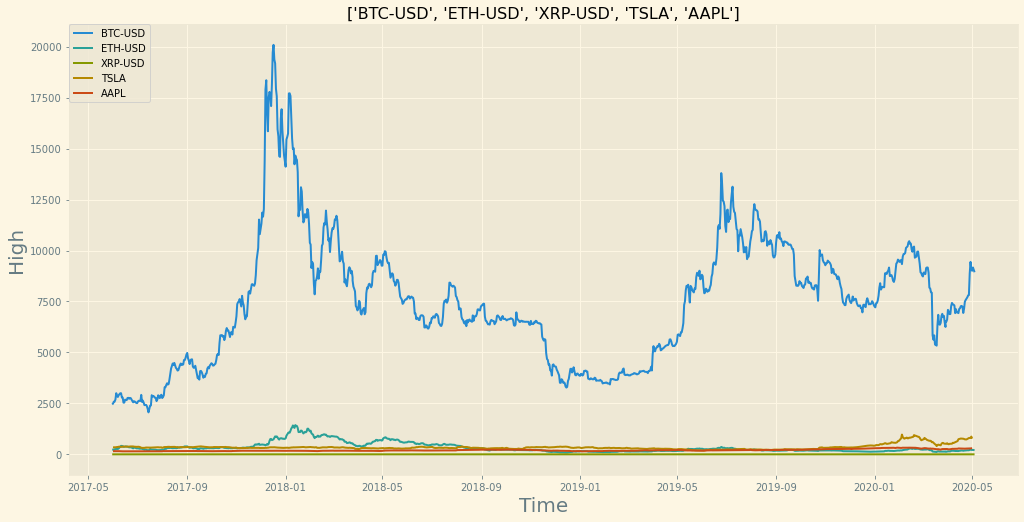

In [3]:
# INSERT COMPANY TICK'S HERE:
# companies_to_plot = [ 'TSLA', 'AAPL' ]
companies_to_plot =[ 'BTC-USD','ETH-USD', 'XRP-USD', 'TSLA', 'AAPL' ]

# INSERT DATE HERE:
start = dt.datetime(2017,6,1)
end = dt.datetime.now()

# REMOVE ALL FILES FROM "stock_dfs" DIRECTORY:
clean_directory("stock_dfs")

# THIS FUNCTION WILL PLOT THE DATA OF MULTIPLE COMPANIES:
compare_companies(companies_to_plot, start, end, "High")

## Naive Forecasting ##

Estimating technique in which the last period's actuals are used as this period's forecast, without adjusting them or attempting to establish causal factors. It is used only for comparison with the forecasts generated by the better (sophisticated) techniques.

Below indicates how to use the naive_forecast() functoin.

You can see that the naive forecast lags 1 step behind the time series.

Number of datapoints: 587
Split time (70%): 410 datapoints 

df_train has: 410 datapoints (Not used in naive forecast)
df_valid has: 177 datapoints
naive_forecast has: 177 datapoints


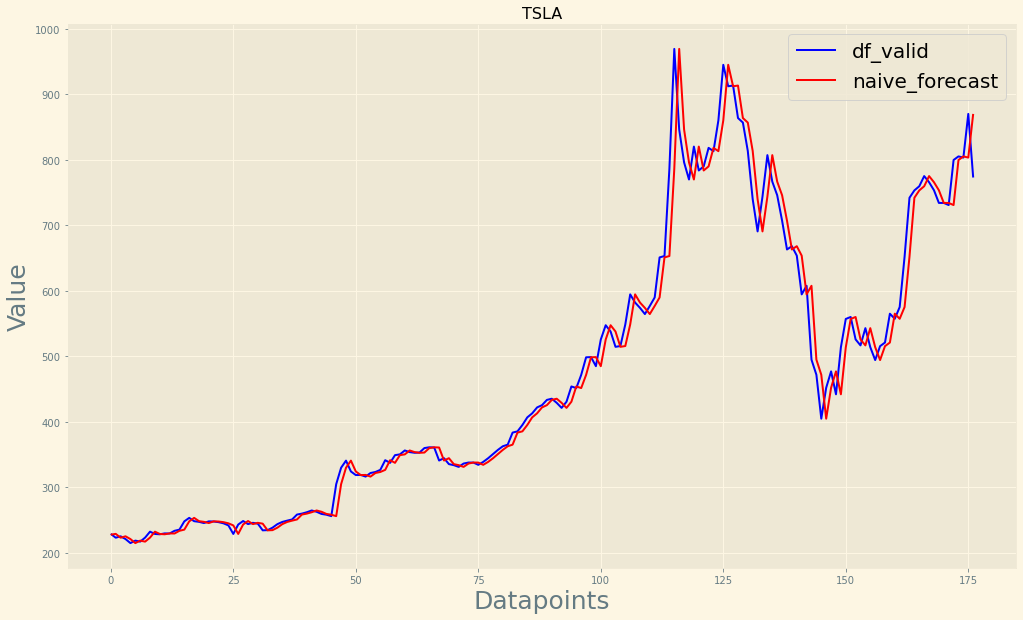

mae:
High    19.242711
dtype: float64

mse:
High    1132.994852
dtype: float64

mape:
High    0.03433
dtype: float64


In [80]:
# INSERT DATE HERE:
start = dt.datetime(2018,1,1)
end = dt.datetime.now()
tick = 'TSLA'
training_data_percentage = 70 

# REMOVE ALL FILES FROM "stock_dfs" DIRECTORY:
clean_directory("stock_dfs")

# GET DATA:
get_data(tick, start, end)

# INSERT COMPANY TICK'S HERE:
df = dataframe(tick, start, end)['High']

# THIS FUNCTION WILL PLOT THE NAIVE FORECAST:
naive_forecast(start, end, df,training_data_percentage)

## Metrics ##

errors = forecasts - actual

mse = np.square(errors).mean()

mae = np.abs(errors).mean()

mape = np.abs(errors / x_valid).mean()

## Moving Average ##

This is just the mean of the past *n* values.

```
Averaging window = 30 days
Forecast = window mean
```

This eliminates most of the noise, but it does not anticipate trend or seasonality. So it can end up preforming worse than naive forecasting. One way to fix this is to remove trend and seasonality from the time series. One can use a simple technique called *Differencing* to do this.



Number of datapoints: 587
Split time (70%): 410 datapoints 

df_train has: 410 datapoints (Not used in moving_avg)
df_valid has: 177 datapoints
moving_avg has: 177 datapoints


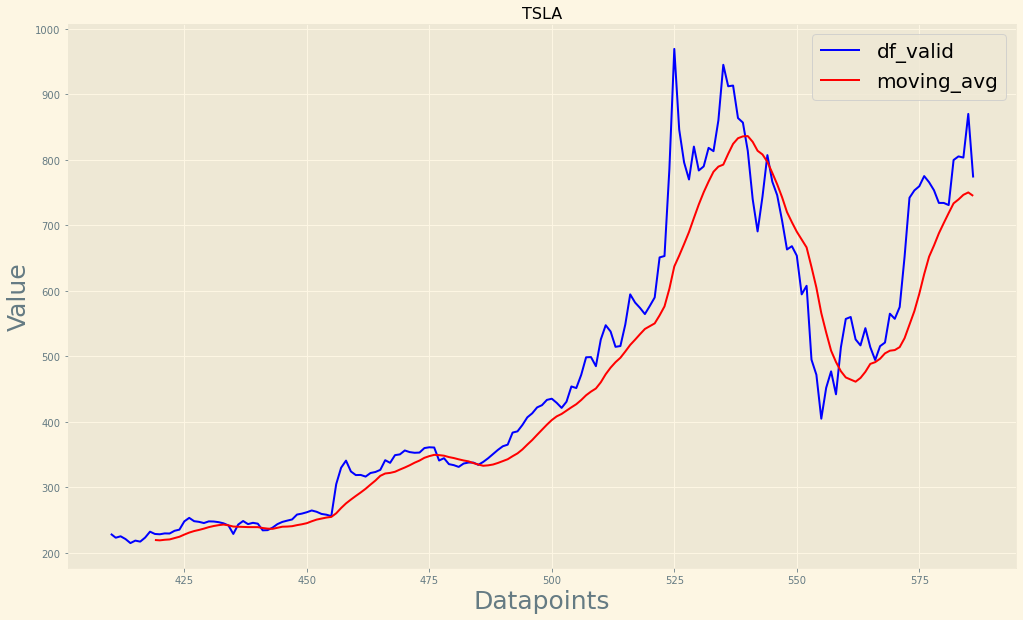

mae:
43.5688309260777

mse:
4214.926232758349

mape:
0.07894582740251856


In [81]:
# INSERT DATE HERE:
start = dt.datetime(2018,1,1)
end = dt.datetime.now()
tick = 'TSLA'
training_data_percentage = 70
window = 10

# REMOVE ALL FILES FROM "stock_dfs" DIRECTORY:
clean_directory("stock_dfs")

# GET DATA:
get_data(tick, start, end)

# CALCULATE MOVING AVERAGE:
moving_average(tick, start, end, training_data_percentage, window)

## Differencing ##

Instead of studying the time series itself, we study the difference between the value at time *t* and the value one year earlier, at time *t* minus 365.

```
Differenced series = series(t) - series(t - 365)

```

We will then get a time series that has no trend and no seasonality. We can then use a moving average to forecast this time series.

However that will give us the forecast for the new "difference" time series not the original time series, To get the final forecasts for the original time series, we need to add back the value at time *t* minus 365

```
Forecasts = moving average of differenced series + series(t - 365)
```




Number of datapoints: 2478
Split time (70%): 1734 datapoints 

df_train has: 1734 datapoints (Not used in moving_avg)
df_valid has: 744 datapoints
moving_avg has: 744 datapoints
2099    347.160004
2100    337.899994
2101    342.000000
2102    347.839996
2103    349.200012
           ...    
2473    799.489990
2474    805.000000
2475    803.200012
2476    869.820007
2477    772.770020
Name: High, Length: 379, dtype: float64


1734    313.940002
1735    316.500000
1736    314.369995
1737    310.730011
1738    311.000000
           ...    
2108    354.000000
2109    349.779999
2110    344.700012
2111    347.109985
2112    348.579987
Name: High, Length: 379, dtype: float64
1734   NaN
1735   NaN
1736   NaN
1737   NaN
1738   NaN
        ..
2473   NaN
2474   NaN
2475   NaN
2476   NaN
2477   NaN
Name: High, Length: 744, dtype: float64


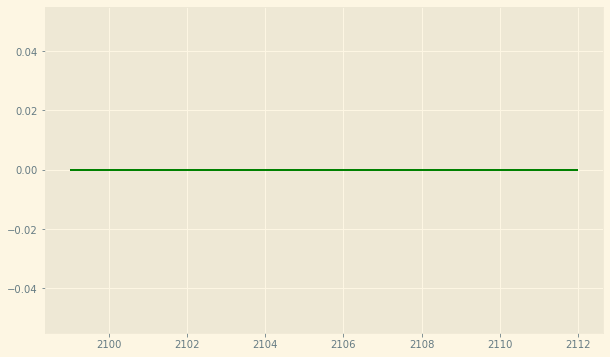

In [101]:
# INSERT DATE HERE:
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
tick = 'TSLA'
training_data_percentage = 70
window = 10


# REMOVE ALL FILES FROM "stock_dfs" DIRECTORY:
clean_directory("stock_dfs")

# GET DATA:
get_data(tick, start, end)

#################################################

df = dataframe(tick, start, end)['High']
df_moving_avg = dataframe(tick, start, end)['Adj Close']


num_of_datapoints = df.tail(1).index.stop
print('Number of datapoints: ' + str(num_of_datapoints))

split_time = percentage_of_days(num_of_datapoints, percentage)
print('Split time (' + str(percentage)+ '%): ' + str(split_time) + ' datapoints \n')
print('df_train has: ' + str(split_time) + ' datapoints (Not used in moving_avg)')
print('df_valid has: ' + str(num_of_datapoints-split_time) + ' datapoints')
print('moving_avg has: ' + str(num_of_datapoints-split_time) + ' datapoints')

df_train = df[:split_time]
df_valid = df[split_time:]

df_moving_avg = df_moving_avg[split_time:]

df_moving_avg = df_moving_avg.rolling(window= window).mean()  # Create a new column for 100 moving average



print(df_valid[365:] )
print('\n')
print(df_valid[:-365] )


diff_series = df_valid[365:] - df_valid[:-365]
# diff_time = time[365:]

print(diff_series)

plt.figure(figsize=(10, 6))
# plt.plot(df_valid,  color='blue', label='df_valid' )  
# plt.plot(df_moving_avg,  color='red', label='moving_avg')
plt.plot( diff_series, color='Green', label='Diff')
plt.show()

In [3]:
# INSERT DATE HERE:
start = dt.datetime(2018,1,1)
end = dt.datetime.now()
tick = 'TSLA'
training_data_percentage = 70 

# REMOVE ALL FILES FROM "stock_dfs" DIRECTORY:
clean_directory("stock_dfs")

# GET DATA:
get_data(tick, start, end)

# INSERT COMPANY TICK'S HERE:
df = dataframe(tick, start, end)

print(df.head())

         Date        High         Low        Open       Close   Volume  \
0  2018-01-02  322.109985  311.000000  312.000000  320.529999  4352200   
1  2018-01-03  325.250000  315.549988  321.000000  317.250000  4521500   
2  2018-01-04  318.549988  305.679993  312.869995  314.619995  9946300   
3  2018-01-05  317.239990  312.000000  316.619995  316.579987  4591200   
4  2018-01-08  337.019989  315.500000  316.000000  336.410004  9859400   

    Adj Close  
0  320.529999  
1  317.250000  
2  314.619995  
3  316.579987  
4  336.410004  
